# Brazilian E-Commerce Public Dataset by Olist

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

sns.set_palette('hls')

## Exploratory Data Analysis

In [5]:
#Reading all .csv files:

customers = pd.read_csv('olist_customers_dataset.csv')
items = pd.read_csv('olist_order_items_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
reviews = pd.read_csv('olist_order_reviews_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')

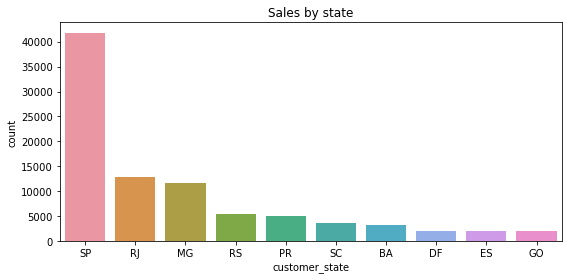

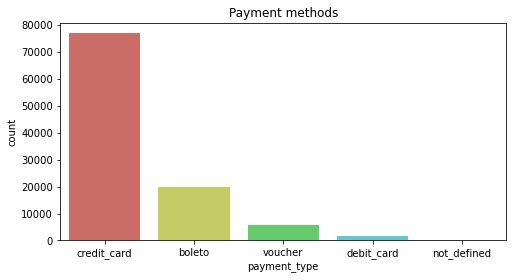

In [23]:
plt.figure(figsize=(8, 4))
sns.countplot(data=customers, 
              x='customer_state', 
              order=customers['customer_state'].value_counts().head(10).index)
plt.title('Sales by state');

plt.figure(figsize=(8, 4))
sns.countplot(data=payments, 
              x='payment_type', 
              order=payments['payment_type'].value_counts().index)
plt.title('Payment methods');

* São Paulo accounts for highest number of sales, followed by Rio de Janeiro and Minas Gerais.
 
* The most common payment method is credit card, chosen more than 70000 times.

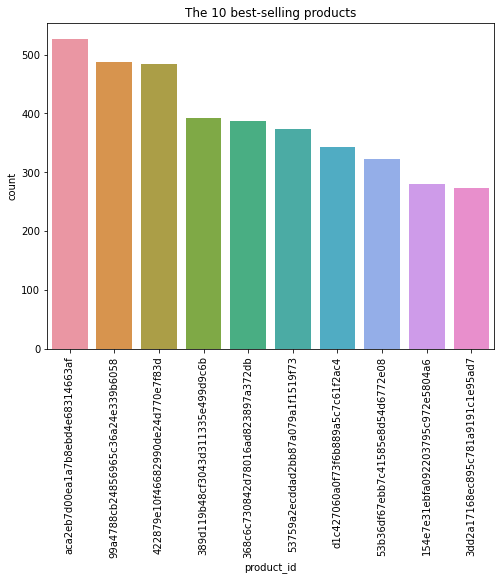

In [7]:
plt.figure(figsize=(8,6))
sns.countplot(data=items,
              x='product_id',
              order=items['product_id'].value_counts().iloc[:10].index)
plt.xticks(rotation=90)
plt.title('The 10 best-selling products');

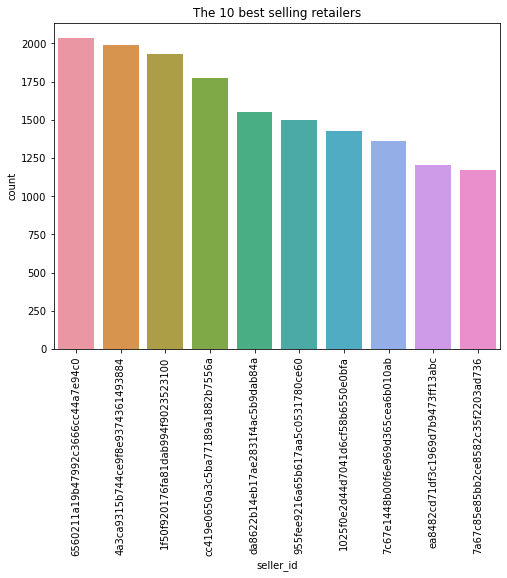

In [8]:
plt.figure(figsize=(8,6))
sns.countplot(data=items,
              x='seller_id',
              order=items['seller_id'].value_counts().iloc[:10].index)
plt.xticks(rotation=90)
plt.title('The 10 best selling retailers');

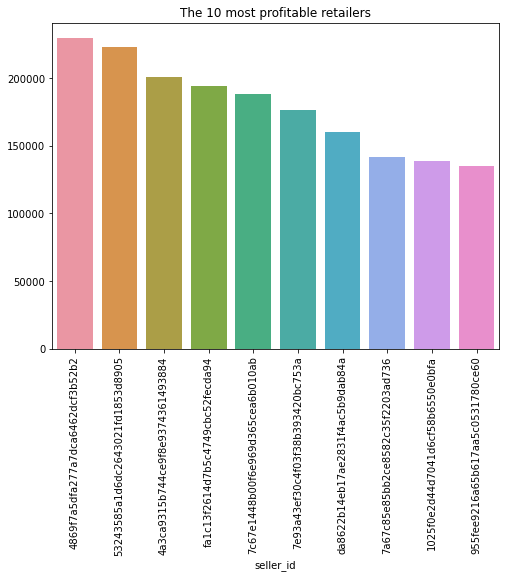

In [9]:
plt.figure(figsize=(8,6))
sns.barplot(data=items,
            x=items.groupby('seller_id')['price'].sum().sort_values(ascending=False).iloc[:10].index,
            y=items.groupby('seller_id')['price'].sum().sort_values(ascending=False).iloc[:10].values)
plt.xticks(rotation=90)
plt.title('The 10 most profitable retailers');

In [10]:
print('Correlation between sold quantity and profit:', items['seller_id'].value_counts().corr(items.groupby('seller_id')['price'].sum().sort_values(ascending=False)))

Correlation between sold quantity and profit: 0.7959552730213906


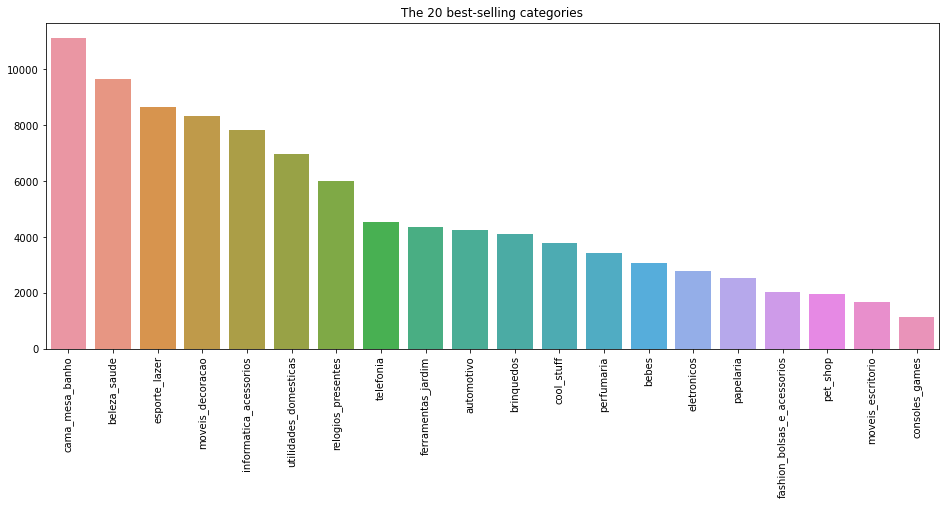

In [11]:
#Merging all sold products and their categories
categories = pd.merge(items['product_id'], products[['product_id','product_category_name']], on='product_id', how='inner')

plt.figure(figsize=(16,6))
sns.countplot(data=categories,
              x='product_category_name',
              order=categories['product_category_name'].value_counts().iloc[:20].index)
plt.xticks(rotation=90)
plt.xlabel(None)
plt.ylabel(None)
plt.title('The 20 best-selling categories');

* The category with the highest number of sales is "Bad, Bath and Table", followed by "Beauty and Health" and "Sport and Leisure"

In [12]:
#Splitting the "purchase timestamp" column into "hour", "day", "month" and "year".

#Hour
orders['purchase_hour'] = pd.to_datetime(orders['order_purchase_timestamp']).dt.hour

#Day
orders['purchase_day'] = pd.to_datetime(orders['order_purchase_timestamp']).dt.day

#Month
orders['purchase_month'] = pd.to_datetime(orders['order_purchase_timestamp']).dt.month

#Year
orders['purchase_year'] = pd.to_datetime(orders['order_purchase_timestamp']).dt.year

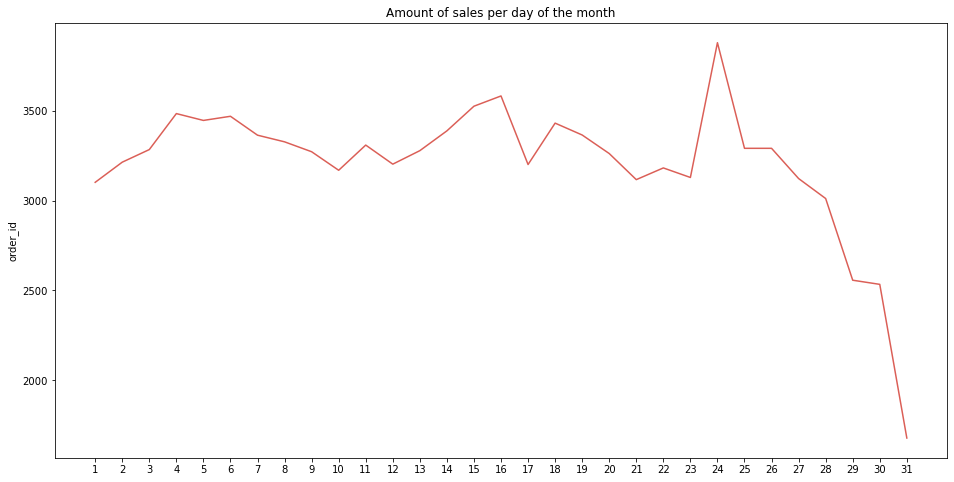

In [13]:
plt.figure(figsize=(16,8))
sns.lineplot(x=sorted(orders['purchase_day'].unique()),
             y=orders.groupby('purchase_day')['order_id'].count().sort_index(ascending=True))
plt.title('Amount of sales per day of the month')
plt.xticks(sorted(orders['purchase_day'].unique()));

* Variation on sales by day of the month isn't very high, except for a peak on the Black Friday period, in November.

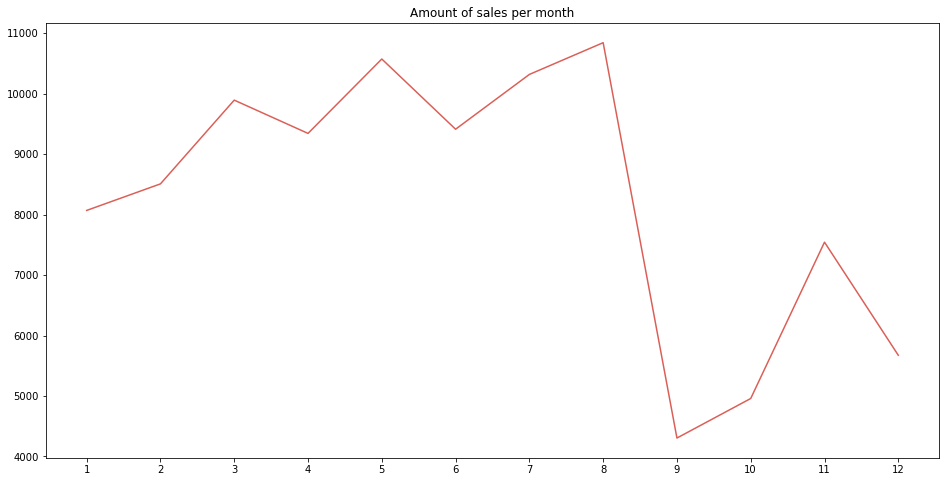

In [14]:
plt.figure(figsize=(16,8))
sns.lineplot(x=sorted(orders['purchase_month'].unique()),
             y=orders.groupby('purchase_month')['order_id'].count().sort_index(ascending=True).values)
plt.title('Amount of sales per month')
plt.xticks(sorted(orders['purchase_month'].unique()));

* There's a visible drop in sales in September.

In [15]:
sales_day_month = pd.DataFrame(pd.pivot_table(orders, index=['purchase_month','purchase_day'], aggfunc='count')['order_id']).reset_index()
sales_day_month.rename(columns={'order_id':'sales_count'}, inplace=True)
month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
               7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

sales_day_month['purchase_month'] = sales_day_month['purchase_month'].map(month_names)

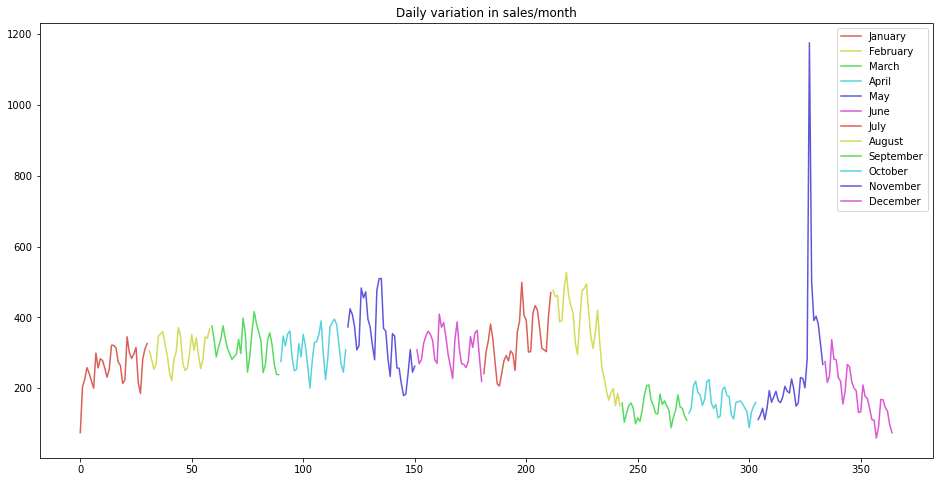

In [16]:
plt.figure(figsize=(16,8))
for month in sales_day_month['purchase_month'].unique():
    sns.lineplot(data=sales_day_month[sales_day_month['purchase_month']==month]['sales_count'], legend='full')
plt.legend(sales_day_month['purchase_month'].unique())
plt.title('Daily variation in sales/month');

In [17]:
#Creating a dataset containing amount of sales per hour
sales_hour = pd.DataFrame(orders['purchase_hour'].value_counts().sort_index())
sales_hour['hour'] = sales_hour.index

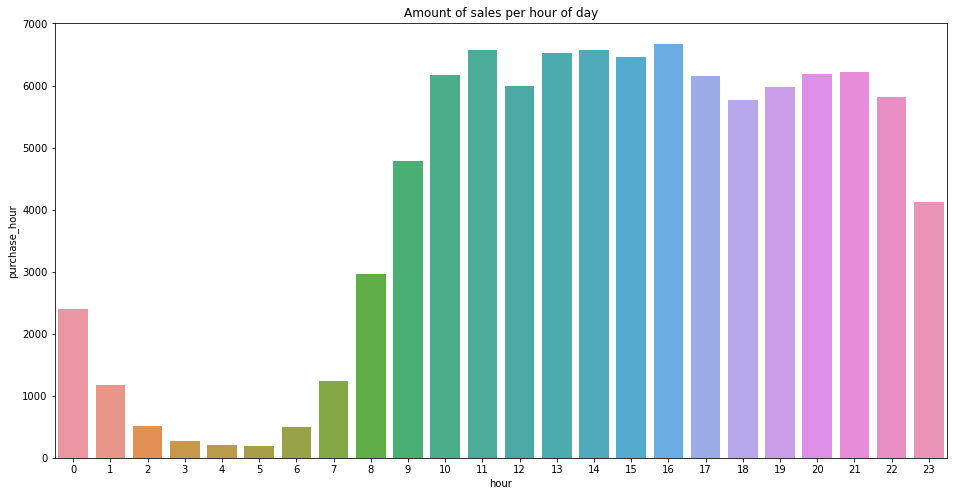

In [18]:
plt.figure(figsize=(16,8))
sns.barplot(data=sales_hour, 
             x='hour',
             y='purchase_hour')
plt.title('Amount of sales per hour of day');

In [19]:
#Creating a dataset containing sales seasonality per month, by category.
seasonality = orders.merge(items, on='order_id', how='left').merge(products, on='product_id', how='left')[['order_id','purchase_month','product_category_name']]

seasonality = pd.DataFrame(pd.pivot_table(seasonality, index=['purchase_month','product_category_name'], aggfunc='count')['order_id']).reset_index()
seasonality['purchase_month'] = seasonality['purchase_month'].map(month_names)

seasonality.head()

,purchase_month,product_category_name,order_id
0,January,agro_industria_e_comercio,21
1,January,alimentos,22
2,January,alimentos_bebidas,11
3,January,artes,19
4,January,artigos_de_festas,2


In [20]:
#Comparing the top 10 best-selling categories monthly
list_sales_cat = []
for i in categories['product_category_name'].value_counts().iloc[:10].index:
    list_sales_cat.append(seasonality[seasonality['product_category_name'] == i]['order_id'].values)

In [21]:
season_top_categories = pd.DataFrame(index=categories['product_category_name'].value_counts().iloc[:10].index,
                                    columns=seasonality['purchase_month'].unique(),
                                    data=list_sales_cat)

season_top_categories

,January,February,March,April,May,June,July,August,September,October,November,December
cama_mesa_banho,896,855,1087,1020,1116,1155,1203,1170,533,553,975,552
beleza_saude,713,834,884,883,1060,1145,1100,1209,383,409,584,466
esporte_lazer,734,807,960,818,808,703,855,900,461,490,612,493
moveis_decoracao,794,700,923,797,884,638,760,869,350,446,783,390
informatica_acessorios,738,1087,932,680,784,669,753,769,253,343,532,287
utilidades_domesticas,387,481,611,654,926,915,853,917,255,247,423,295
relogios_presentes,381,374,511,602,771,605,696,628,268,319,469,367
telefonia,398,470,516,429,480,379,369,413,178,263,383,267
ferramentas_jardim,298,368,412,407,432,299,369,376,225,286,550,325
automotivo,302,405,431,444,436,412,461,543,108,162,263,268


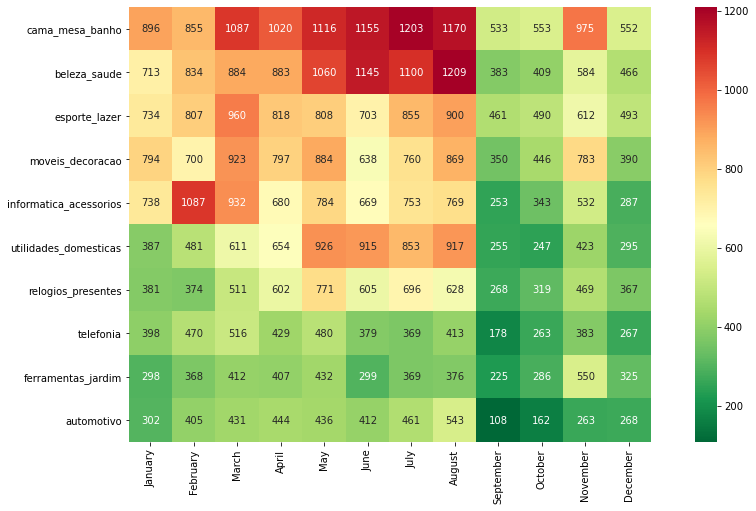

In [22]:
plt.figure(figsize=(16,8))
sns.heatmap(season_top_categories, square=True, annot=True, fmt='d', cmap='RdYlGn_r');